In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.torch_geo_models import DotMLPRelu
from src.data.gamma.structural_pubmed import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.mlp import StructuralOmegaMLP

In [6]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/pubmed/02-1-structural_mlp_gamma_function.log'
)

In [7]:
torch.cuda.is_available()

True

In [8]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [9]:
dataset = load_dataset()

In [10]:
dataset[0].edge_index

tensor([[    0,     0,     0,  ..., 19714, 19715, 19716],
        [ 1378,  1544,  6092,  ..., 12278,  4284, 16030]])

In [11]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [12]:
data = prepare_adjencency(data)

## Training

In [13]:
data.x.shape

torch.Size([19717, 500])

In [14]:
data.x

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0194, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
        [0.1078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0266, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [15]:
data.y

tensor([1, 1, 0,  ..., 2, 0, 2], device='cuda:0')

In [16]:
for run in range(10):
    for n_layers in range(1, 6):
        omega = StructuralOmegaMLP(
            device,
            dataset='pubmed',
            in_channels=data.x.shape[1],
            n_layers=n_layers,
            run=run
        )
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y.reshape(-1, 1))


KeyboardInterrupt: 

## Results

### For a Layer Number

In [17]:
n_layers = 3

In [18]:
metrics = StructuralOmegaMLP.read_metrics(dataset='pubmed', n_layers=n_layers)
print(metrics.shape)
metrics.head()

(714, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.689262,0.688982,0.689089,0.487635,0.459498,0.484432
1,0,100,0.462735,0.431742,0.445564,0.713352,0.718177,0.709511
2,0,200,0.429990,0.423415,0.431724,0.760768,0.740211,0.732087
3,0,300,0.412152,0.426205,0.430263,0.787655,0.742691,0.740144
4,0,400,0.393425,0.424585,0.430372,0.811398,0.746398,0.745299


### Sumarize metrics per epoch

In [19]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [20]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [21]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.693493,0.012202,0.693504,0.013112,0.693500,0.012752,0.506813,0.029348,0.503811,0.044963,0.504428,0.034089
100,0.462247,0.003288,0.431397,0.002613,0.444997,0.002636,0.713751,0.003226,0.718512,0.003369,0.709667,0.002243
200,0.430779,0.002800,0.423644,0.001118,0.432187,0.000822,0.760064,0.004349,0.741324,0.001332,0.731810,0.001160
300,0.413983,0.005895,0.426434,0.001855,0.431885,0.001961,0.785566,0.007661,0.742651,0.002441,0.738462,0.003053
400,0.396905,0.009242,0.426448,0.003012,0.432600,0.002101,0.808005,0.010777,0.743676,0.003470,0.742596,0.003248


In [22]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
700,0.350401,0.014592,0.442237,0.020871,0.442300,0.005119,0.857365,0.013299,0.746475,0.005420,0.744924,0.003631
600,0.366463,0.013246,0.432698,0.014039,0.438423,0.003579,0.842852,0.013122,0.745929,0.005038,0.744811,0.003551
800,0.336681,0.019067,0.464453,0.023621,0.447267,0.005509,0.870136,0.014883,0.745507,0.006461,0.743283,0.005140
500,0.380099,0.012008,0.426330,0.004045,0.434043,0.002354,0.827500,0.011966,0.745397,0.004593,0.744799,0.003607
900,0.322551,0.021409,0.473041,0.021605,0.454400,0.009607,0.880383,0.016158,0.744663,0.005404,0.742097,0.004865


/tmp/ipykernel_390047/483979402.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_390047/483979402.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_390047/483979402.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavio

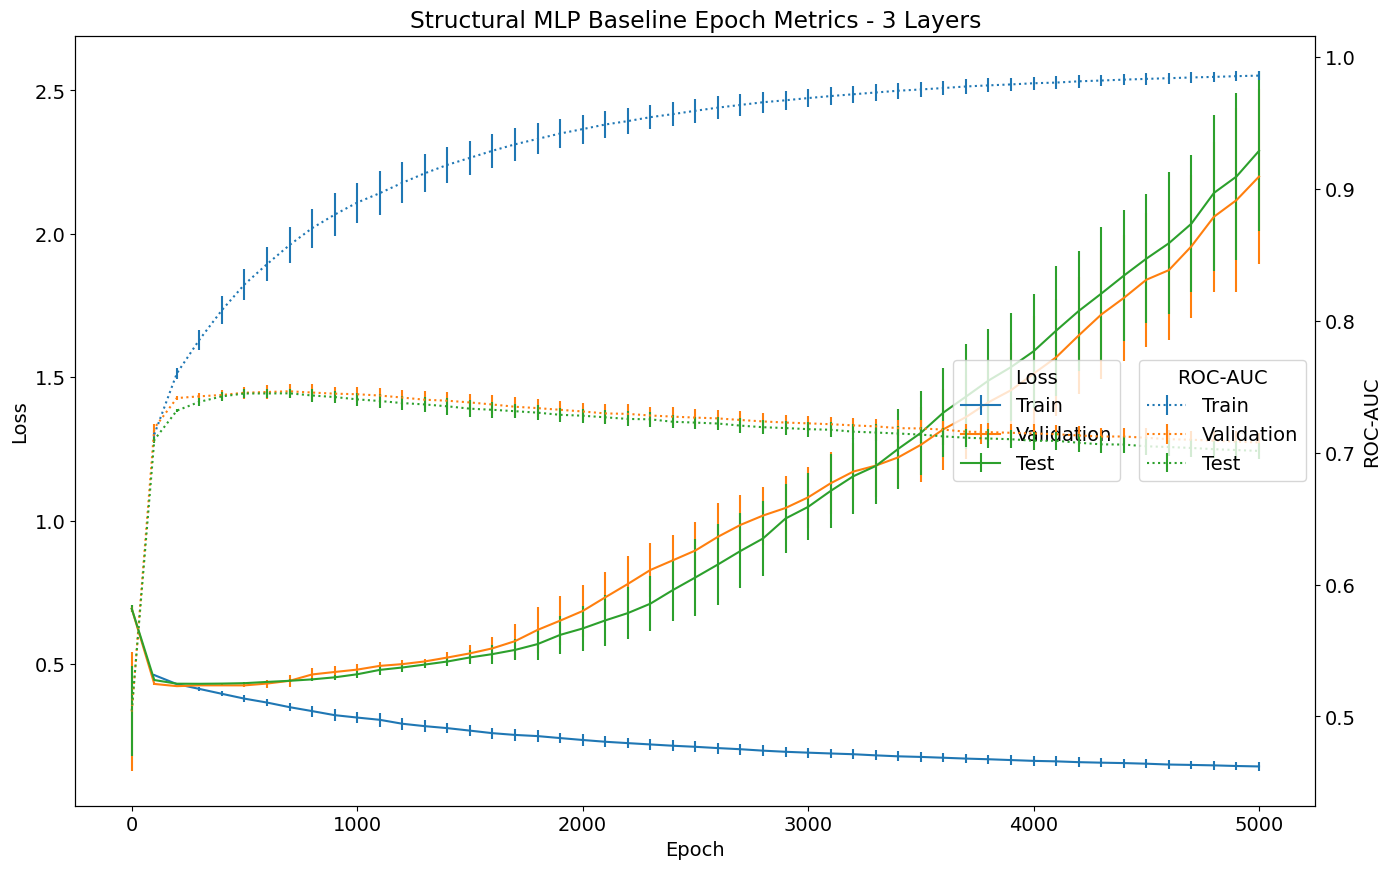

In [23]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title(f'Structural MLP Baseline Epoch Metrics - {n_layers} Layers')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC-AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC-AUC')

plt.savefig(f'reports/images/pubmed/structural_omega_dotmlp_training_metrics_{n_layers}layers.pdf')

### Comparing Validation Performance for All Layer numbers

In [24]:
n_layers_list = range(1, 6)

In [25]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers in n_layers_list:
    metrics = StructuralOmegaMLP.read_metrics(dataset='pubmed', n_layers=n_layers)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers] = auc_val
    mean_loss_val_dict[n_layers] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers] = auc_val
    std_loss_val_dict[n_layers] = loss_val

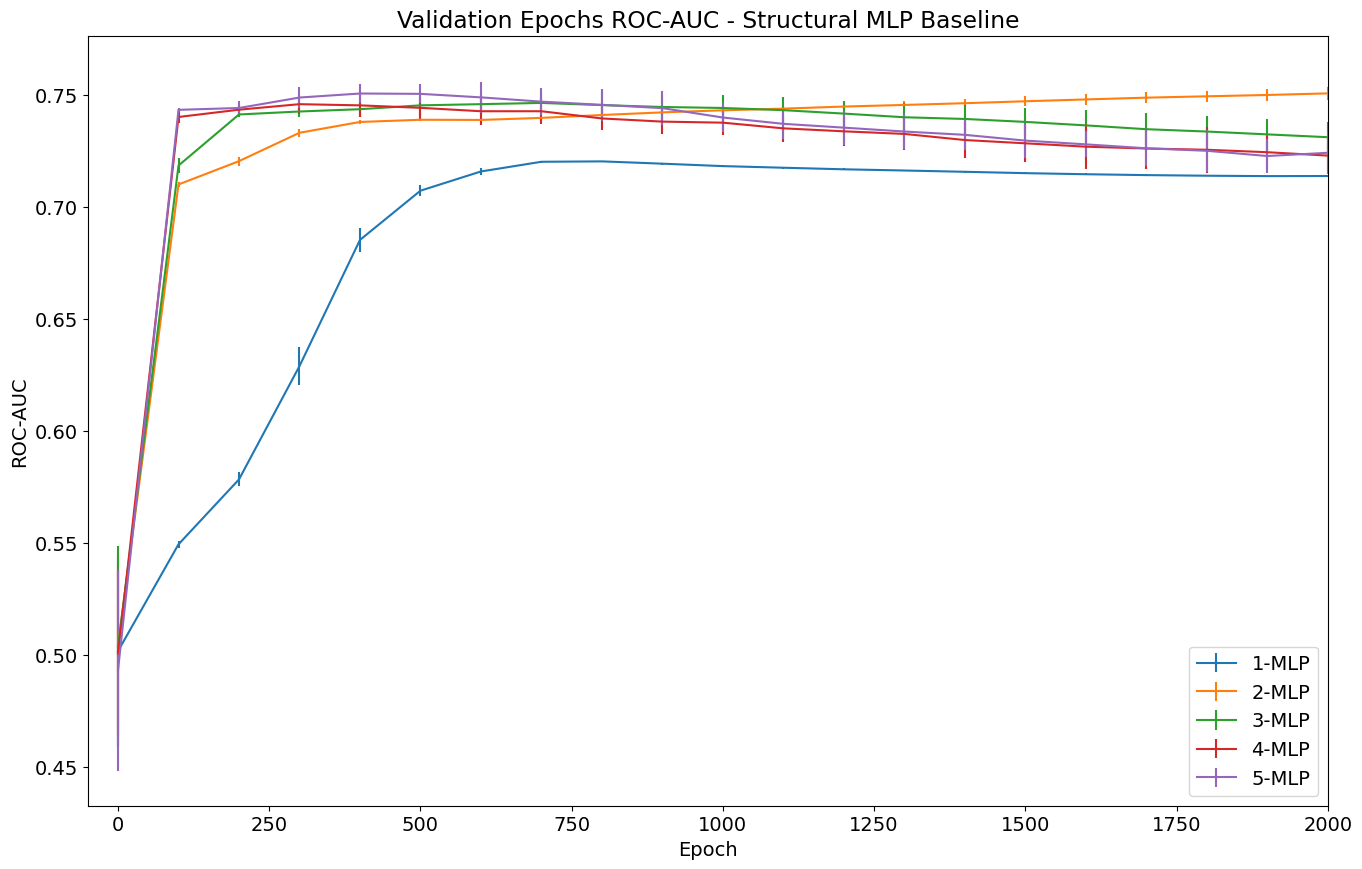

In [26]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation Epochs ROC-AUC - Structural MLP Baseline')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'{n_layers}-MLP')

ax1.set_xlim(-50, 2000)

ax1.legend()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC-AUC')

plt.savefig(f'reports/images/pubmed/structural_omega_dotmlp_training_metrics_multilayer_validation.pdf')